# Embedding Adjustments

> In this notebook, I investigate the adjustments to the input embedding that occur within a block and their impact on the output logits/probabilities.

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

In [ ]:
# | hide
import gc
from pathlib import Path
from typing import Callable, Dict, List, Optional, Iterable, Sequence, Tuple

In [ ]:
#| hide
from fastcore.test import *
import math
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch.nn import functional as F
from tqdm.auto import tqdm

In [ ]:
# | hide

from transformer_experiments.common.substring_generator import all_unique_substrings
from transformer_experiments.common.svd_helpers import adjust_singular_vector_sign
from transformer_experiments.common.text_analysis import (
    build_next_token_map,
)
from transformer_experiments.dataset_split import split_text_dataset
from transformer_experiments.datasets.tinyshakespeare import (
    TinyShakespeareDataSet,
)
from transformer_experiments.environments import get_environment
from transformer_experiments.models.transformer import (
    block_size,
    n_embed,
    n_layer,
    TransformerLanguageModel
)
from transformer_experiments.models.transformer_helpers import (
    unsqueeze_emb,
    EncodingHelpers,
    LogitsWrapper,
    InputOutputAccessor,
    TransformerAccessors
)
from transformer_experiments.trained_models.tinyshakespeare_transformer import (
    create_model_and_tokenizer,
    FilenameForToken,
)
from transformer_experiments.experiments.cosine_sims import (
    filter_on_prefiltered_results,
)


## Preliminaries

In [ ]:
environment = get_environment()
print(f"environment is {environment.name}")

environment is local_mac


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ts = TinyShakespeareDataSet(cache_file=environment.code_root / 'nbs/artifacts/input.txt')
m, tokenizer = create_model_and_tokenizer(
    saved_model_filename=environment.code_root / 'nbs/artifacts/shakespeare-20231112.pt',
    dataset=ts,
    device=device,
)
_, val_data = split_text_dataset(ts.text, tokenizer, train_pct=0.9, device=device)
encoding_helpers = EncodingHelpers(tokenizer, device)
accessors = TransformerAccessors(m, device)

In [ ]:
# Get all the unique substrings of length 10 from the text
strings10 = all_unique_substrings(text=ts.text, substring_length=10)

In [ ]:
torch.manual_seed(1442)
n_prompts = 20000

torch.manual_seed(1337)
indices = torch.randperm(len(strings10))[:n_prompts]
prompts = [strings10[i.item()] for i in indices]
prompts[:5]

['is dreams,', 'by present', 's eyes may', 'eart of ho', ' man, as I']

In [ ]:
# Tokenize the strings
tokens = encoding_helpers.tokenize_strings(prompts)

# Embed the tokens
accessors = TransformerAccessors(m, device)
embeddings = accessors.embed_tokens(tokens)

# Run them through the model with hooks attached that let us look at
# intermediate values
_, io_accessors = accessors.run_model(embeddings)

## Define Some Helpful Functions

In [ ]:
def logits_from_block_output(block_output: torch.Tensor, block_idx: int) -> torch.Tensor:
    # If we're not at the last layer, run the rest of the model, otherwise
    # just get the logits from the embedding.
    if block_idx < n_layer - 1:
        logits, _ = accessors.run_model_from_block_n(block_output, block_idx+1)
    else:
        logits = accessors.logits_from_embedding(block_output)
    return logits

def probs_from_logits(logits: torch.Tensor) -> torch.Tensor:
    return F.softmax(logits, dim=-1)

In [ ]:
def get_intermediates(block_idx: int, io_accessors: Sequence[InputOutputAccessor]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    block_input = io_accessors[block_idx].input('.')
    sa_output = io_accessors[block_idx].output('sa')
    ffwd_output = io_accessors[block_idx].output('ffwd')
    block_output = io_accessors[block_idx].output('.')

    # Sanity check: block output is the sum of the block input, sa_output,
    # and ffwd_output.
    assert torch.all(block_output == block_input + sa_output + ffwd_output)

    # Sanity check: the block output is the same as the next block's input
    if block_idx < n_layer - 1:
        assert torch.all(block_output == io_accessors[block_idx+1].input('.'))

    return sa_output, ffwd_output, block_output

In [ ]:
def hellinger_distance(
    p: torch.Tensor,
    q: torch.Tensor,
):
    return ((p.sqrt() - q.sqrt())**2).sum(dim=-1).sqrt() / math.sqrt(2)

## Analysis

Within a block, the input embedding is adjusted twice: first by adding the output of the self-attention module, then by adding the output of the feed-forward network to that sum:

```python
class Block(nn.Module):
    """One transformer block"""

    ...

    def forward(self, x):
        x = x + self.sa(self.ln1(x)) # The `x +` part is a skip connection
        x = x + self.ffwd(self.ln2(x)) # The `x +` part is a skip connection

        return x
```

This is equivalent to the following code, which, by using some intermediate local variables, makes the two adjustments a little clearer:

```python
    def forward(self, x):
        sa_output = self.sa(self.ln1(x))
        ffwd_output = self.ffwd(self.ln2(x + sa_output))

        return x + sa_output + ffwd_output
```

The output of the block is the original embedding, plus the self-attention output, plus the feed-forward network output. 

In this analysis, we'll look at the impact of each of the two adjustments on the final output of the model. Specifically, compute the output logits from the original output of the block and compare this to the output logits that the model would have produced had the self-attention output not been added (i.e. if the block output had been just `x + ffwd_output`) and if the feed-forward network output had not been added (`x + sa_output`). We'll also look at the impact on output probabilities. 

In [ ]:
def analyze_intermediate_impact(
    block_idx: int,
    sa_output: torch.Tensor,
    ffwd_output: torch.Tensor,
    block_output: torch.Tensor,
):
    print(f"Block {block_idx}")

    # Get the logits that would have been produced by the normal block
    # output. This is the baseline we're comparing against.
    logits = logits_from_block_output(block_output[:, -1, :].unsqueeze(1), block_idx)

    # Get the logits that would have been produced by the block output
    # minus the self-attention output.
    logits_no_sa = logits_from_block_output(
        (block_output - sa_output)[:, -1, :].unsqueeze(1), block_idx
    )

    # Get the logits that would have been produced by the block output
    # minus the feed-forward network output.
    logits_no_ffwd = logits_from_block_output(
        (block_output - ffwd_output)[:, -1, :].unsqueeze(1), block_idx
    )

    # Subtract the modified logits from the baseline logits and get the norms.
    no_sa_diff_norms = (logits - logits_no_sa).norm(dim=-1)
    no_ffwd_diff_norms = (logits - logits_no_ffwd).norm(dim=-1)

    # Print stats
    print(
        f"                                 Average norm of logits: {logits.norm(dim=-1).mean():>5.2f} ± {logits.norm(dim=-1).std():.2f}"
    )
    print(
        f"                Average norm of (logits - logits_no_sa): {no_sa_diff_norms.mean():>5.2f} ± {no_sa_diff_norms.std():.2f}"
    )
    print(
        f"              Average norm of (logits - logits_no_ffwd): {no_ffwd_diff_norms.mean():>5.2f} ± {no_ffwd_diff_norms.std():.2f}"
    )

    print()

    # Compute probabilities from the baseline logits and the modified logits.
    # Then compute the Hellinger distance between the two sets of probabilities.
    h_no_sa = hellinger_distance(
        probs_from_logits(logits), probs_from_logits(logits_no_sa)
    )
    h_no_ffwd = hellinger_distance(
        probs_from_logits(logits), probs_from_logits(logits_no_ffwd)
    )

    # Print stats
    print(
        f"  Average h(probs_from_logits, probs_from_logits_no_sa): {h_no_sa.mean():>5.2f} ± {h_no_sa.std():.2f}, "
    )
    print(
        f"Average h(probs_from_logits, probs_from_logits_no_ffwd): {h_no_ffwd.mean():>5.2f} ± {h_no_ffwd.std():.2f}"
    )
    _, ax = plt.subplots(figsize=(8, 6))
    sns.kdeplot(data=h_no_sa.cpu().numpy(), fill=False, color="blue", ax=ax, label='h(probs_from_logits, probs_from_logits_no_sa)')
    sns.kdeplot(data=h_no_ffwd.cpu().numpy(), fill=False, color="orange", ax=ax, label='h(probs_from_logits, probs_from_logits_no_ffwd)')
    ax.legend()

Block 0
                                 Average norm of logits: 26.64 ± 4.02
                Average norm of (logits - logits_no_sa):  3.31 ± 1.23
              Average norm of (logits - logits_no_ffwd): 20.65 ± 5.88

  Average h(probs_from_logits, probs_from_logits_no_sa):  0.11 ± 0.07, 
Average h(probs_from_logits, probs_from_logits_no_ffwd):  0.70 ± 0.17


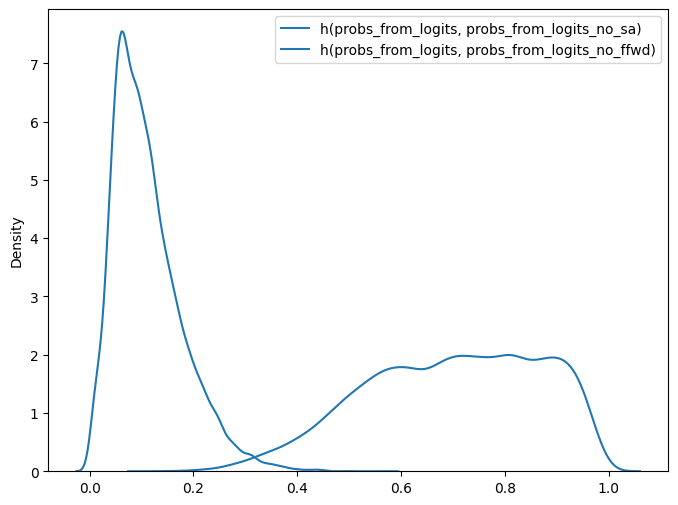

In [ ]:
block_idx = 0
sa_output, ffwd_output, block_output = get_intermediates(block_idx, io_accessors)
analyze_intermediate_impact(block_idx, sa_output, ffwd_output, block_output)

Block 1
                                 Average norm of logits: 28.01 ± 4.02
                Average norm of (logits - logits_no_sa):  2.08 ± 0.75
              Average norm of (logits - logits_no_ffwd):  5.43 ± 1.72

  Average h(probs_from_logits, probs_from_logits_no_sa):  0.07 ± 0.04, 
Average h(probs_from_logits, probs_from_logits_no_ffwd):  0.19 ± 0.11


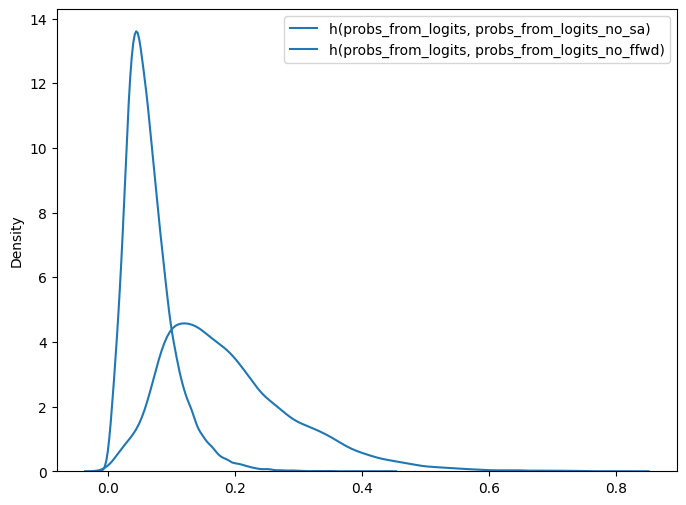

In [ ]:
block_idx = 1
sa_output, ffwd_output, block_output = get_intermediates(block_idx, io_accessors)
analyze_intermediate_impact(block_idx, sa_output, ffwd_output, block_output)

Block 2
                                 Average norm of logits: 29.60 ± 4.22
                Average norm of (logits - logits_no_sa):  2.91 ± 1.39
              Average norm of (logits - logits_no_ffwd):  4.68 ± 1.61

  Average h(probs_from_logits, probs_from_logits_no_sa):  0.09 ± 0.07, 
Average h(probs_from_logits, probs_from_logits_no_ffwd):  0.15 ± 0.10


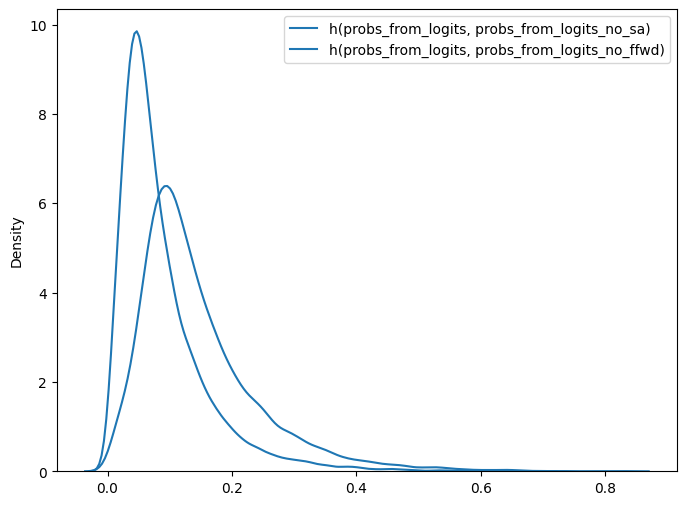

In [ ]:
block_idx = 2
sa_output, ffwd_output, block_output = get_intermediates(block_idx, io_accessors)
analyze_intermediate_impact(block_idx, sa_output, ffwd_output, block_output)

Block 3
                                 Average norm of logits: 30.64 ± 4.15
                Average norm of (logits - logits_no_sa):  2.70 ± 1.13
              Average norm of (logits - logits_no_ffwd):  4.72 ± 1.83

  Average h(probs_from_logits, probs_from_logits_no_sa):  0.06 ± 0.05, 
Average h(probs_from_logits, probs_from_logits_no_ffwd):  0.13 ± 0.10


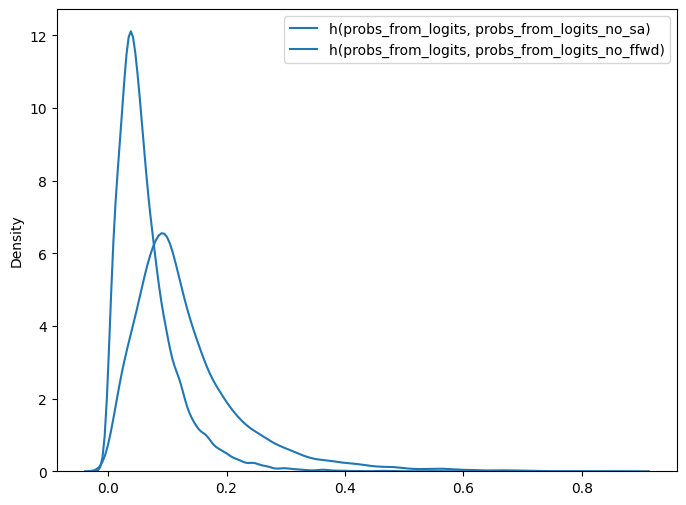

In [ ]:
block_idx = 3
sa_output, ffwd_output, block_output = get_intermediates(block_idx, io_accessors)
analyze_intermediate_impact(block_idx, sa_output, ffwd_output, block_output)

Block 4
                                 Average norm of logits: 31.22 ± 4.18
                Average norm of (logits - logits_no_sa):  2.07 ± 0.71
              Average norm of (logits - logits_no_ffwd):  5.45 ± 2.13

  Average h(probs_from_logits, probs_from_logits_no_sa):  0.04 ± 0.03, 
Average h(probs_from_logits, probs_from_logits_no_ffwd):  0.14 ± 0.10


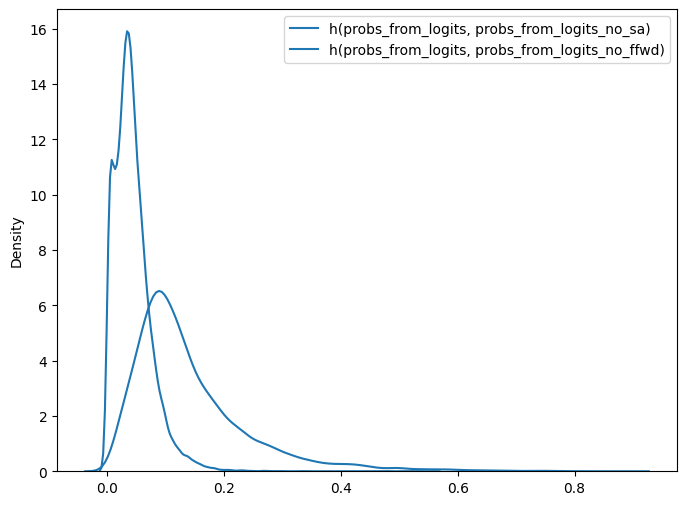

In [ ]:
block_idx = 4
sa_output, ffwd_output, block_output = get_intermediates(block_idx, io_accessors)
analyze_intermediate_impact(block_idx, sa_output, ffwd_output, block_output)

Block 5
                                 Average norm of logits: 31.61 ± 4.21
                Average norm of (logits - logits_no_sa):  1.84 ± 0.61
              Average norm of (logits - logits_no_ffwd):  7.55 ± 3.09

  Average h(probs_from_logits, probs_from_logits_no_sa):  0.03 ± 0.03, 
Average h(probs_from_logits, probs_from_logits_no_ffwd):  0.17 ± 0.10


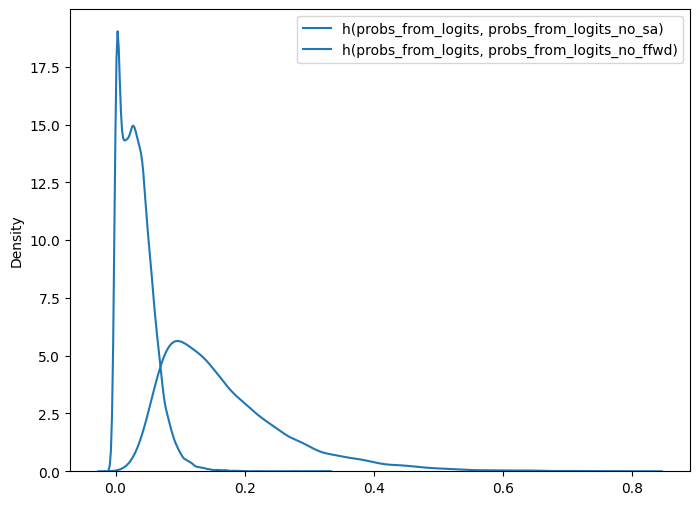

In [ ]:
block_idx = 5
sa_output, ffwd_output, block_output = get_intermediates(block_idx, io_accessors)
analyze_intermediate_impact(block_idx, sa_output, ffwd_output, block_output)

The magnitude varies per block, but it seems that the feed-forward network output has a much larger impact on the final output of the model at each block. 